In [96]:
# increase the output width to cover all
# the summary columns in a single row
options(width = 210) 

# imports
library('ggplot2')
library('dplyr')
library('pwr')

In [3]:
# read wine data from files
red_wine = read.csv('data/wine/winequality-red.csv', sep=';')
white_wine = read.csv('data/wine/winequality-white.csv', sep=';')

# replace spaces in column names by underscores 
# for better data manipulation in the code
colnames(red_wine) <- gsub('\\.', '_', colnames(red_wine))
colnames(white_wine) <- gsub('\\.', '_', colnames(white_wine))

In [42]:
# output initial rows to get some initial insight  
# into the general structure of the data
head(red_wine)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [90]:
describe_col <- function(x) {
  c(
    Min = min(x, na.rm = TRUE),
    `1st Qu.` = quantile(x, 0.25, na.rm = TRUE),
    Median = median(x, na.rm = TRUE),
    Mean = mean(x, na.rm = TRUE),
    `3rd Qu.` = quantile(x, 0.75, na.rm = TRUE),
    Max = max(x, na.rm = TRUE),
    SD = sd(x, na.rm = TRUE)
  )
}

describe <- function(df) {
    summary <- df %>%
      reframe(across(everything(), describe_col))
    summary <- as.data.frame(summary)
    rownames(summary) = c('Min', '1st Qu.', 'Median', 'Mean', '3rd Qu.', 'Max', 'SD')
    return(summary)
}

cat(toupper('Red wine:'), nrow(red_wine), 'records', '\n')
red_wine_summary <- describe(red_wine)
print(red_wine_summary)
cat('\n')
cat(toupper('White wine:'), nrow(white_wine), 'records', '\n')
white_wine_summary <- describe(white_wine)
print(white_wine_summary)
cat('\n')

RED WINE: 1599 records 
        fixed_acidity volatile_acidity citric_acid residual_sugar  chlorides free_sulfur_dioxide total_sulfur_dioxide     density        pH sulphates   alcohol   quality
Min          4.600000        0.1200000   0.0000000       0.900000 0.01200000             1.00000              6.00000 0.990070000 2.7400000 0.3300000  8.400000 3.0000000
1st Qu.      7.100000        0.3900000   0.0900000       1.900000 0.07000000             7.00000             22.00000 0.995600000 3.2100000 0.5500000  9.500000 5.0000000
Median       7.900000        0.5200000   0.2600000       2.200000 0.07900000            14.00000             38.00000 0.996750000 3.3100000 0.6200000 10.200000 6.0000000
Mean         8.319637        0.5278205   0.2709756       2.538806 0.08746654            15.87492             46.46779 0.996746679 3.3111132 0.6581488 10.422983 5.6360225
3rd Qu.      9.200000        0.6400000   0.4200000       2.600000 0.09000000            21.00000             62.00000 0.997835

Number of samples: 20


	Welch Two Sample t-test

data:  fixed_acidity_red and fixed_acidity_white
t = 2.7259, df = 28.584, p-value = 0.005415
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.3895543       Inf
sample estimates:
mean of x mean of y 
    8.080     7.045 


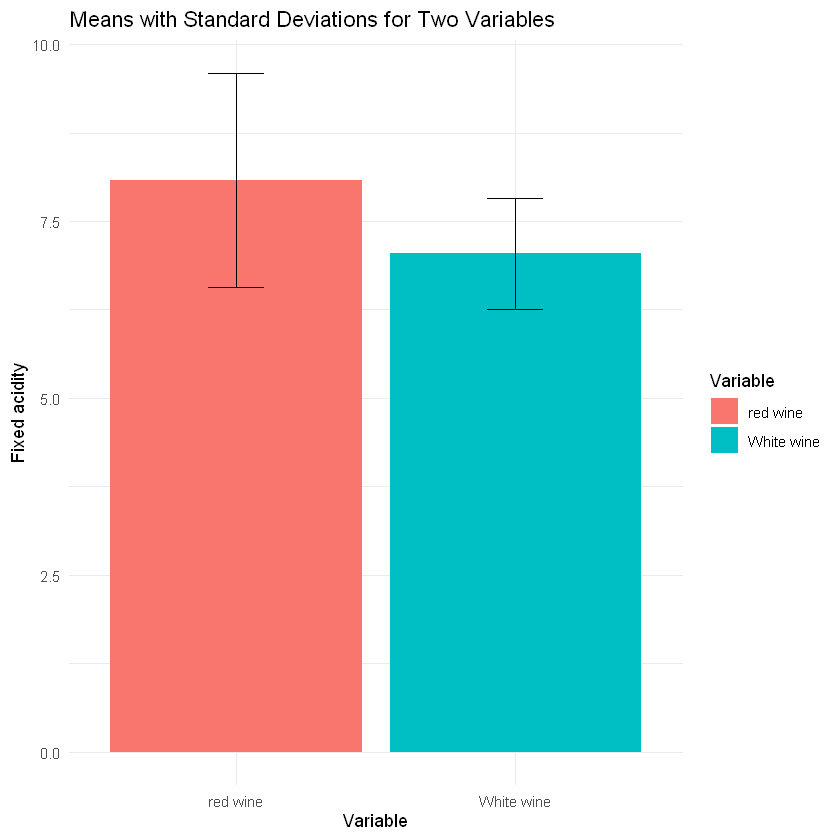

In [177]:
# investigate the fixed acidity

cohen_d <- function(x, y) {
    # Calculates the Cohen's d (effect size) that represents 
    # the difference between two means divided by the pooled 
    # standard deviation.
    #
    # Cohen's d is used to estimate the effect size between
    # two groups.
    #
    # Parameters:
    # -----------
    # x: numeric
    #    First sample (group 1).
    # 
    # y: numeric
    #    Second sample (group 2).
    #
    # Returns:
    # --------
    # numeric
    #    The calculated Cohen's d, representing the standardized  
    #    difference between the means of the two groups.
    
    # Sample sizes (assuming equal sample sizes for simplicity)
    n1 <- length(x)
    n2 <- length(y)
    
    # means
    mean1 <- mean(x)
    mean2 <- mean(y)
    
    # Standard deviations
    sd1 <- sd(x, na.rm = TRUE)
    sd2 <- sd(y, na.rm = TRUE)
    
    # Pooled standard deviation
    sd_pooled <- sqrt(((n1 - 1) * sd1^2 + (n2 - 1) * sd2^2) / (n1 + n2 - 2))
    
    # Cohen's d
    d <- (mean2 - mean1) / sd_pooled

    # result
    return(d)
    
}

# determine the sample size from which the t-test will be performed
cohen_d_val <- cohen_d(white_wine$fixed_acidity, red_wine$fixed_acidity)

result <- pwr.t.test(
    n= NULL,
    d = cohen_d_val,
    sig.level=0.05, # standard experiment, so using 5% alpha
    power=0.80, # keep it to 80% to avoid type II error
    type='two.sample',
    alternative='greater' # greater for red wine
)

# n_samples = ceiling(round(result$n)) # produces too few samples
N_SAMPLES = 20
cat('Number of samples:', N_SAMPLES)

fixed_acidity_red <- sample_n(red_wine, N_SAMPLES)$fixed_acidity
fixed_acidity_white <- sample_n(white_wine, N_SAMPLES)$fixed_acidity

# plot mean and SD to see how the params
# vary in the particular kinds of wine
mean_red <- mean(fixed_acidity_red)
mean_white <- mean(fixed_acidity_white)
sd_red <- sd(fixed_acidity_red)
sd_white <- sd(fixed_acidity_white)

summary_stats <- data.frame(
    Variable = c('red wine', 'White wine'),
    Mean = c(mean_red, mean_white),
    SD = c(sd_red, sd_white)
)

ggplot(summary_stats, aes(x = Variable, y = Mean, fill = Variable)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.9)) +
  geom_errorbar(aes(ymin = Mean - SD, ymax = Mean + SD), width = 0.2, position = position_dodge(width = 0.9)) +
  labs(title = "Means with Standard Deviations for Two Variables", y = "Fixed acidity") +
  theme_minimal()

# perform t-test on the selected params from red wine and white wine
t.test(fixed_acidity_red, fixed_acidity_white, alternative='greater')